# Needed libraries

In [2]:
pip install tensorflow_hub

In [3]:
pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 31.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [6]:
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from random import randint
import seaborn as sn
import requests
from sklearn.metrics import roc_curve, roc_auc_score

#Dataset

In [5]:
from google.colab import drive as colab_drive
colab_drive.mount('/content/drive', force_remount=True)

MessageError: ignored

In [8]:

df = pd.read_csv('/content/lyrics_dataframe_clean_1.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

,lyrics,genere
0,\nyo i never fucked wayne i never fucked drake...,rap
1,\nyo b they ready\nlet's go\n\nfeelin' myself ...,rap
2,\nuh mmm kyuh\nrip to big \nclassic shit\n\ni'...,rap
3,\nyou know yeah\ntouchin' yeah\nnight of\nyou ...,rap
4,\nayo look like i'm goin' for a swim\ndunked o...,rap
...,...,...
10990,\nmonkey see monkey do i don't know why\nwalk ...,rock
10991,\nthey hung him on a cross\nthey hung him on a...,rock
10992,\nclean up before she comes\nclean up before s...,rock
10993,\ni'm not gonna make you groom\nsomewhere else...,rock


In [9]:
print(df['lyrics'][0])


yo i never fucked wayne i never fucked drake
on my life man fuck's sake
if i did i'd ménage with 'em
and let 'em eat my ass like a cupcake
my man full he just ate
i don't duck nobody but tape
yeah that was a setup
for a punchline on duct tape
wo-wo-wo-worried 'bout if my butt fake
wo-worried 'bout y'all niggas us straight
th-these girls are my sons
jo-jon & kate plus eight
when i walk in zip up straight
i don't give a fuck if i was late
dinner with my man on a g5
is my idea of a update
hut-hut one hut-hut two
big titties big butt too
fu-fuck with them real niggas
who don't tell niggas what they up to
had to show bitches where the top is
ri-ring finger where the rock is
the-these hoes couldn't test me
even if their name was pop quiz
bad bitches who i fuck with
ma-ma-mad bitches we don't fuck with
i don't fuck with them chickens
unless they last name is cutlet
let it soak in
like seasoning
and tell them bitches blow me
lance stephenson
you might also like
raise every bottle and cup in t

Replacing the categorical data with numerical ones

In [10]:
df['genere'].replace('rap', 0, inplace = True)
df['genere'].replace('pop', 1, inplace = True)
df['genere'].replace('country', 2, inplace = True)
df['genere'].replace('rock', 3, inplace = True)

Since all the data is ordered, we will shuffle the dataset randomly

In [11]:
df = df.sample(frac = 1)
df


,lyrics,genere
10007,\nticking away the moments that make up a dull...,3
2106,\ntell me when the guns are left around\nwanna...,0
3651,\neach day each day i play the role\nof someon...,1
5407,i'm with my little girl the only friend left i...,2
7996,\nmy house of memories is all i own\ni live in...,2
...,...,...
6131,not long ago in the heat of the summer\nmama s...,2
10928,\nshe had a moist vagina\ni particularly enjoy...,3
9132,charlie don't surf and we think he should\ncha...,3
3264,\nshe's like cold coffee in the morning\ni'm d...,1


## Test and train

In [12]:
X = df.drop(['genere'], axis=1)
y = df['genere']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

#BERT

These are the links needed to import the BERT preprocessor and encoder.

In [13]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

Here we create the models

In [14]:
bert_perprocess_model = hub.KerasLayer(preprocess_url, name='preprocessing')
bert_model = hub.KerasLayer(encoder_url, name='BERT_encoder')

For this model we will use a functional architecture so we can pass each layer to each layer we want.

In [15]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

# here the bert preprocessor will do the tokenization and segment embeddings for us
preprocessed_text = bert_perprocess_model(text_input)
#since bert return a dictionary, all we need is the pooled_output key because that
#key return the vector for the song
bert_output = bert_model(preprocessed_text)['pooled_output']

In [16]:
bert_output.shape

TensorShape([None, 768])

# FFNN

Here we create a functional model with the first layer a dropout layer which takes as input the vector generated by the bert model. It will be then passed to a dense layer which will do the classification.

In [17]:
input_layer = tf.keras.layers.Dropout(0.25, name='dropout')(bert_output)
output_layer = tf.keras.layers.Dense(4, activation='softmax', name = 'output')(input_layer)

In [18]:
model = tf.keras.Model(inputs=[text_input], outputs=[output_layer])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

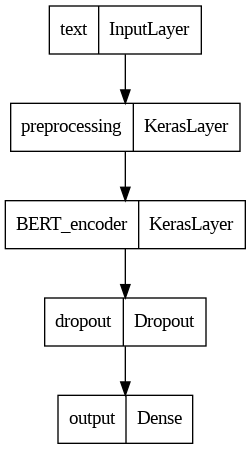

In [19]:
tf.keras.utils.plot_model(model)

Here we compile the model and with trial and error we decided that these values are appropriate for our episolon and learning_rate.

In [20]:
opt = tf.keras.optimizers.AdamW(
    learning_rate=0.008,
    epsilon=1e-07
)


In this case it was needed to use sparse_categorical_crossentropy for the loss function and AdamW as our optimizer because these selected parameters perform the best with multiclass text classification according to our research.

In [21]:
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Training of the model

In [22]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
121/121 [==============================] - 149s 1s/step - loss: 1.3158 - accuracy: 0.4561 - val_loss: 0.9712 - val_accuracy: 0.5808
Epoch 2/10
121/121 [==============================] - 134s 1s/step - loss: 1.0563 - accuracy: 0.5530 - val_loss: 0.8884 - val_accuracy: 0.6356
Epoch 3/10
121/121 [==============================] - 135s 1s/step - loss: 0.9611 - accuracy: 0.5886 - val_loss: 0.9826 - val_accuracy: 0.5784
Epoch 4/10
121/121 [==============================] - 135s 1s/step - loss: 0.9981 - accuracy: 0.5812 - val_loss: 0.8461 - val_accuracy: 0.6550
Epoch 5/10
121/121 [==============================] - 135s 1s/step - loss: 0.9922 - accuracy: 0.5878 - val_loss: 0.8264 - val_accuracy: 0.6751
Epoch 6/10
121/121 [==============================] - 135s 1s/step - loss: 0.9570 - accuracy: 0.6012 - val_loss: 0.8271 - val_accuracy: 0.6599
Epoch 7/10
121/121 [==============================] - 136s 1s/step - loss: 0.9969 - accuracy: 0.5910 - val_loss: 1.0819 - val_accuracy: 0.5280

#Model evaluation

In this piece of code we append the max value of each list from the result the function above returns. Here we append the index of that value which in the same time is also the numerical value of the genere corresponding to that song. This all is needed for the classification report  

In [23]:
yp = model.predict(X_test)

y_pred = []
for element in yp:
    for i, val in enumerate(element):
        if element[i] == max(element):
            y_pred.append(i)



104/104 [==============================] - 38s 359ms/step


## Classification report

In [ ]:
print(classification_report(y_test, y_pred))

As expected, our model if performing better in rap and country because these to genres are most distinguishable from the other two.

### Learning curve

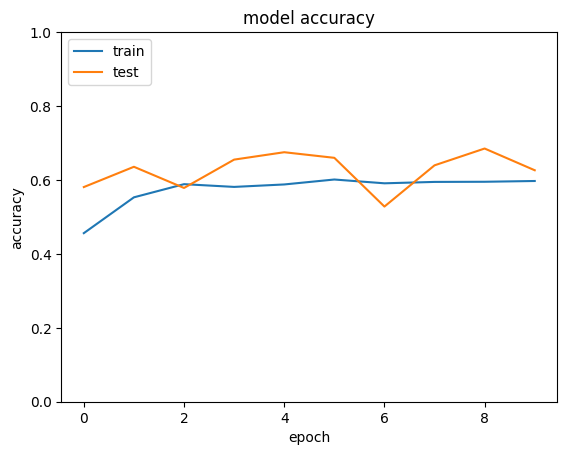

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As we can see the model is not converging fairly well but this can be blamed on the capacity of the machine to run train this model for a lot of epochs or the high complexity of the data we are dealing with.

##Confusion matrix

In [ ]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

As even seen in the EDA section of this project, the obvious difference between rap and the other generes is present even here.

We can see that especially rap and country have the less misclassifications between each other and this result was expected because these song differ a lot in all statistics done on them, such as word count, line count, the special words used and so on.

We can see that our model struggles a lot with pop and this might be due to the similarity of the structure of this genre with rock. They have almost the same lengths, the same word countr and even the almost the same popular words used.

Country just like rap has a more distinguished structure. The songs are shorter, less special words used and this makes it different from the other generes.